Approach: simulate data for two groups for Normal distribution.
* Group 1: mean 0, sd= sigma1
* Group 2: mean = effect, sd = sigma.  

For each simulated dataset you run:
A two-sample t-test on the original values.
The same t-test on pooled ranks (rank-transform t‑test).

Repeat this many times and estimate the power of each method:

(Power = how often the test correctly detects a real difference.)

Then,

1.Fix sample size (e.g., n = 30 per group) and change the effect size (how big the difference in means is).
    For each effect size, compute power for both tests and plot the two curves.

2.Fix effect size and vary the sample size (e.g., n = 10, 20, 30, …).
    Again compute power for both tests and plot.

We get the curves side by side:
    Left: power vs effect size (raw vs ranks).
    Right: power vs n (raw vs ranks).


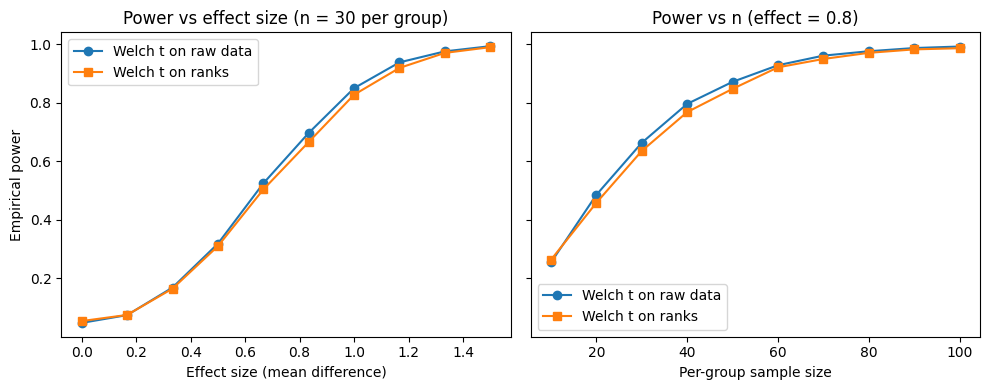

In [ ]:
"""Power comparison: t-test on raw data vs. t-test on rank-transformed data.

"""
from __future__ import annotations

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def simulate_power(
    effect: float,
    n_per_group: int,
    n_sim: int = 5000,
    sigma1: float = 1.0,
    sigma2: float = 1.0,
    alpha: float = 0.05,
    use_welch: bool = True,
    random_state: int | None = None,
) -> tuple[float, float]:
    """Estimate power of raw- and rank-based two-sample t-tests.

    Parameters
    ----------
    effect:
        Mean difference between groups on the original scale (group 2 mean).
    n_per_group:
        Sample size per group.
    n_sim:
        Number of Monte Carlo replications.
    sigma1, sigma2:
        Standard deviations of the two groups (may differ to induce
        heteroscedasticity).
    alpha:
        Significance level for declaring a rejection.
    use_welch:
        If True, use Welch's unequal-variance t-test; otherwise use the
        equal-variance Student t-test.
    random_state:
        Optional seed for reproducibility.

    Returns
    -------
    p_raw, p_rank:
        Estimated power for the test on raw data and on rank-transformed data.
    """

    rng = np.random.default_rng(random_state)

    rejections_raw = 0
    rejections_rank = 0

    for _ in range(n_sim):
        x = rng.normal(loc=0.0, scale=sigma1, size=n_per_group)
        y = rng.normal(loc=effect, scale=sigma2, size=n_per_group)

        # t-test on original data
        res_raw = stats.ttest_ind(x, y, equal_var=not use_welch)
        if res_raw.pvalue < alpha:
            rejections_raw += 1

        # t-test on pooled ranks
        pooled = np.concatenate([x, y])
        ranks = stats.rankdata(pooled, method="average")
        ranks_x = ranks[:n_per_group]
        ranks_y = ranks[n_per_group:]

        res_rank = stats.ttest_ind(ranks_x, ranks_y, equal_var=not use_welch)
        if res_rank.pvalue < alpha:
            rejections_rank += 1

    p_raw = rejections_raw / n_sim
    p_rank = rejections_rank / n_sim
    return p_raw, p_rank


def power_vs_effect(
    effects: np.ndarray,
    n_per_group: int,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """Compute power curves as a function of effect size.

    Returns arrays (power_raw, power_rank) aligned with `effects`.
    """
    power_raw = np.empty_like(effects, dtype=float)
    power_rank = np.empty_like(effects, dtype=float)

    for i, eff in enumerate(effects):
        p_raw, p_rank = simulate_power(effect=eff, n_per_group=n_per_group, **kwargs)
        power_raw[i] = p_raw
        power_rank[i] = p_rank

    return power_raw, power_rank


def power_vs_n(
    ns: np.ndarray,
    effect: float,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """Compute power curves as a function of per-group sample size.

    Returns arrays (power_raw, power_rank) aligned with `ns`.
    """
    power_raw = np.empty_like(ns, dtype=float)
    power_rank = np.empty_like(ns, dtype=float)

    for i, n in enumerate(ns):
        p_raw, p_rank = simulate_power(effect=effect, n_per_group=int(n), **kwargs)
        power_raw[i] = p_raw
        power_rank[i] = p_rank

    return power_raw, power_rank


def main() -> None:
    """Run the simulation and plot the two sets of power curves."""

    # Grid for effect-size curves
    effects = np.linspace(0.0, 1.5, 10)
    n_fixed = 30

    # Heteroscedastic example: sigma2 > sigma1
    sigma1, sigma2 = 1.0, 1.5

    pow_raw_eff, pow_rank_eff = power_vs_effect(
        effects,
        n_per_group=n_fixed,
        sigma1=sigma1,
        sigma2=sigma2,
        use_welch=True,  # Toggle to False to compare Student t instead
    )

    # Grid for sample-size curves
    ns = np.arange(10, 101, 10)
    effect_fixed = 0.8

    pow_raw_n, pow_rank_n = power_vs_n(
        ns,
        effect=effect_fixed,
        sigma1=sigma1,
        sigma2=sigma2,
        use_welch=True,
    )

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # Panel 1: power vs effect size
    ax = axes[0]
    ax.plot(effects, pow_raw_eff, marker="o", label="Welch t on raw data")
    ax.plot(effects, pow_rank_eff, marker="s", label="Welch t on ranks")
    ax.set_xlabel("Effect size (mean difference)")
    ax.set_ylabel("Empirical power")
    ax.set_title(f"Power vs effect size (n = {n_fixed} per group)")
    ax.legend()

    # Panel 2: power vs sample size
    ax = axes[1]
    ax.plot(ns, pow_raw_n, marker="o", label="Welch t on raw data")
    ax.plot(ns, pow_rank_n, marker="s", label="Welch t on ranks")
    ax.set_xlabel("Per-group sample size")
    ax.set_title(f"Power vs n (effect = {effect_fixed})")
    ax.legend()

    fig.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

Both methods show increasing power with larger effect sizes and larger sample sizes.

For these normal, equal‑variance simulations, the standard t‑test on raw data is slightly more powerful than the t‑test on ranks (curves for raw data are a bit higher).

A t‑test on rank‑transformed data is often called a rank‑transform test; it combines rank robustness with t‑test machinery and can be useful when one wants to use linear‑model tools while reducing sensitivity to non‑normality or unequal variances compared to classic rank tests like Mann–Whitney, which assume equal variances.